In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import os, sys
import pandas as pd
import sklearn
import sklearn.svm, sklearn.discriminant_analysis
import time
import scipy.stats
import copy
import statsmodels
from statsmodels.stats.anova import AnovaRM

root = '/usr/local/serenceslab/maggie/shapeDim/'
sys.path.append(os.path.join(root, 'Analysis'))
from code_utils import file_utils, data_utils, plot_utils, stats_utils, grid_utils

In [2]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 12)
figfolder = os.path.join(root, 'Analysis','figures')

In [3]:
task_names = ['Linear (1)','Linear (2)','Checker', 'Repeat'];
n_tasks = len(task_names)
task_colors = np.flipud(cm.GnBu(np.linspace(0,1,5))[1:,:])

n_subjects = 10
subjects = np.arange(1,11)
subcolors = cm.Dark2(np.linspace(0,1,n_subjects))

In [4]:
lab = dict()
for ss in subjects:
    
    # get labels for all the trials, this subject
    main_labels = data_utils.load_main_task_labels(ss)
    rep_labels = data_utils.load_repeat_task_labels(ss)
    lab[ss] = pd.concat([main_labels, rep_labels], axis=0)
    

In [5]:
save_folder = os.path.join(root, 'Analysis', 'decoding_results')
save_filename = os.path.join(save_folder, 'decode_binary_withintask.npy')
print(save_filename)
print(time.ctime(os.path.getmtime(save_filename)))
dec = np.load(save_filename, allow_pickle=True).item()
dec.keys()
roi_names = dec['roi_names']
n_rois = len(roi_names)

/usr/local/serenceslab/maggie/shapeDim/Analysis/decoding_results/decode_binary_withintask.npy
Wed Aug 14 23:11:22 2024


In [6]:
dec['acc_bytask'].shape

(10, 8, 4, 3)

#### accuracy along each linear axis, in each task

In [7]:
n_tasks = 4

# conf_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
# acc_allmaintrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_fartrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

conf_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))
acc_midtrials = np.zeros((n_subjects, n_rois, n_tasks, 2))

for si, ss in enumerate(subjects):

    for ti, tt in enumerate([1,2,3,4]):
        
        l = lab[ss][lab[ss]['task']==tt]
        
        pt_labs = np.array([l['ptx'], l['pty']]).T
        is_main_grid = l['is_main_grid']==1
        
        for ii in [0,1]:

            # actual labels for position along this axis
            coord_actual = pt_labs[:,ii]
            # actual category along this axis
            categ_actual = np.array(l['categ_task%d'%(ii+1)])
    
            dist_from_center = np.array(l['dist_from_bound%d'%(ii+1)]).round(1)
            # hard trials are closest to bound (variable grid)
            # easy is the furthest from bound
            # medium is second furthest
            # is_hard = dist_from_center<0.8
            is_far = (dist_from_center==2.4) & is_main_grid
            is_middle = (dist_from_center==0.8) & is_main_grid
           
            is_correct = np.array(l['subject_correct'])
            
            for ri in range(n_rois):

                # switching categs here so that 1=coord<center, 2=coord>center
                categ_pred = 3-dec['preds_all'][si][ri][ti][ii].astype(int)
             
                prob = dec['probs_all'][si][ri][ti][ii]
                
                p_categ1 = prob[:,1]
                p_categ2 = prob[:,0]
                
                signedconf = np.zeros_like(p_categ1)
                signedconf[categ_actual==1] = p_categ1[categ_actual==1] - p_categ2[categ_actual==1]
                signedconf[categ_actual==2] = p_categ2[categ_actual==2] - p_categ1[categ_actual==2]

    
#                 # all trials
#                 inds = is_main_grid & is_correct
            
#                 conf_allmaintrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
#                 acc_allmaintrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # easy trials
                inds = is_far & is_correct
                
                conf_fartrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_fartrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                
                # medium trials
                inds = is_middle & is_correct
                
                conf_midtrials[si,ri,ti,ii] = np.mean(signedconf[inds])
            
                acc_midtrials[si,ri,ti,ii] = np.mean(categ_pred[inds]==categ_actual[inds])
                

In [8]:
plt.rcParams['pdf.fonttype']=42
plot_utils.set_all_font_sizes(fs = 16)
figfolder = os.path.join(root, 'Analysis','figures')

-0.004785178720303676 0.8645591093252586
0.0005883959763682185 0.7707390848894271
-0.006866030798125323 0.8908006712197483
0.011765613477083358 0.9560474671587766
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_Far.pdf
-0.06178037657112232 0.5273746045448482
-0.030014562891179524 0.4272916080095726
-0.10018657968388078 0.5594594179967135
-0.03293575126279938 0.6958627031991086
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/binary_conf_Near.pdf


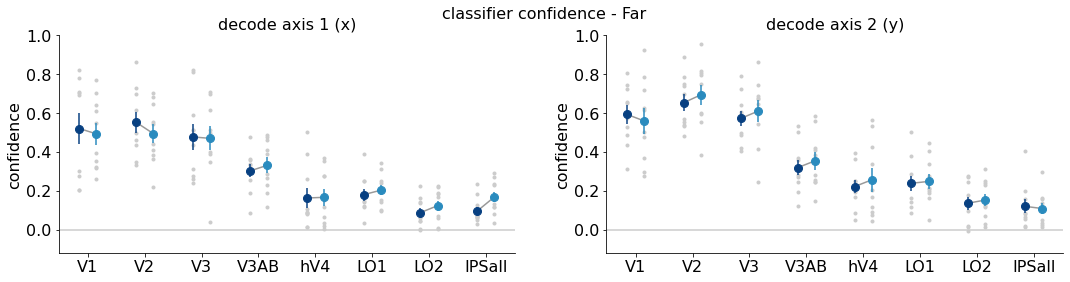

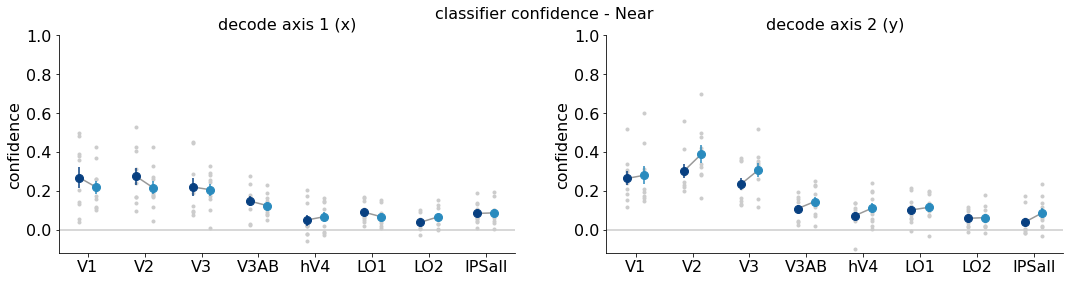

In [10]:
ti_plot = [0,1]

x_jitter = np.linspace(-0.15, 0.15, 2)

for rvals, name in zip([conf_fartrials, conf_midtrials], \
                     ['Far','Near']):
    
    plt.figure(figsize=(18,4))

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        ax = plt.subplot(1,2,ii+1)

        plt.axhline(0, color=[0.8, 0.8, 0.8])

        lh = []

        for ti in ti_plot:

            x_ticks = np.arange(n_rois) + x_jitter[ti]

            vals = rvals[:,:,ti,ii]
            print(np.min(vals), np.max(vals))
            meanvals = np.mean(vals, axis=0)
            semvals = np.std(vals, axis=0)/np.sqrt(n_subjects-1)

            plt.plot(x_ticks, meanvals, 'o', color=task_colors[ti], alpha=1, markersize=8)
            h = plt.errorbar(x_ticks, meanvals, semvals, xerr=None, color=task_colors[ti], linestyle='none')
            lh.append(h)
            
        for ri in range(n_rois):
            
            meanvals = np.mean(rvals[:,ri,ti_plot,ii], axis=0)
            plt.plot([ri+x_jitter[0], ri+x_jitter[1]], meanvals,'-',color=[0.6, 0.6, 0.6], zorder=-5)

            plt.plot(ri+x_jitter, rvals[:,ri,ti_plot,ii].T, '.', color=[0.8, 0.8, 0.8], zorder=-10)
            
        plt.ylim([-0.12, 1.0])

        plt.xticks(np.arange(n_rois), roi_names)
        plt.ylabel('confidence')

        # plt.legend(lh,np.array(task_names)[ti_plot])

        plt.title('decode %s'%axis_name)
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)


    plt.suptitle('classifier confidence - %s'%name)

    figname = os.path.join(figfolder, 'binary_conf_%s.pdf'%name)
    print(figname)
    plt.savefig(figname)

In [11]:

for xx, [cvals, diffname] in enumerate(zip([conf_fartrials, \
                                            conf_midtrials], \
                        ['far','middle'])):

    
    vals = copy.deepcopy(cvals[:,:,0:2,0:2])

    anova_result = stats_utils.rmanova_3way(vals, ['ROI','Task','Boundary'], \
                                            # do_shuffle=False)
                                           do_shuffle=True, n_iter=10000, rndseed = 423443+xx)

    anova_result['Pr > F'] = anova_result['Pr > F'].round(4)

    tablename = os.path.join(figfolder, 'decodebinary_binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    
    print(tablename)
    anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_lin1vs2_rm_anova_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_lin1vs2_rm_anova_middle.csv


In [11]:
for diffname in ['far','middle']:
    
    tablename = os.path.join(figfolder, 'decodebinary_binary_conf_lin1vs2_rm_anova_%s.csv'%(diffname))
    print(tablename)
    print(time.ctime(os.path.getmtime(tablename)))
    anova_result = pd.read_csv(tablename, index_col=0)
    print('\nAnova for confidence, %s trials'%(diffname))
    
    print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_lin1vs2_rm_anova_far.csv
Sat Dec 14 08:55:32 2024

Anova for confidence, far trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                64.262346     7.0    63.0  0.0000           0.0000
Task                2.113408     1.0     9.0  0.1800           0.1786
Boundary           27.521426     1.0     9.0  0.0005           0.0005
ROI:Task            0.565561     7.0    63.0  0.7810           0.7804
ROI:Boundary        3.489850     7.0    63.0  0.0032           0.0033
Task:Boundary       0.164076     1.0     9.0  0.6949           0.7052
ROI:Task:Boundary   0.937452     7.0    63.0  0.4844           0.4898
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_lin1vs2_rm_anova_middle.csv
Sat Dec 14 09:11:04 2024

Anova for confidence, middle trials
                     F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI                38.410904     7

In [13]:
for cvals, diffname in zip([conf_fartrials, conf_midtrials ], \
                        ['far','middle']):

    for ii, axis_name in enumerate(['axis1','axis2']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])

        anova_result = stats_utils.rmanova_2way(vals, ['ROI','Task'], \
                                                # do_shuffle=False)
                                                do_shuffle=True, n_iter=10000, rndseed = 243434+ii)

        
        anova_result['Pr > F'] = anova_result['Pr > F'].round(4)
    
        tablename = os.path.join(figfolder, 'decodebinary_binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
    
        print(tablename)
        anova_result.to_csv(tablename)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis1_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis2_far.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis1_middle.csv
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis2_middle.csv


In [12]:
for diffname in ['far','middle']:
    for axis_name in ['axis1','axis2']:

        tablename = os.path.join(figfolder, 'decodebinary_binary_conf_rm_anova_%s_%s.csv'%(axis_name, diffname))
        print(tablename)
        print(time.ctime(os.path.getmtime(tablename)))
        anova_result = pd.read_csv(tablename, index_col=0)
        print('\nAnova for %s confidence, %s trials'%(axis_name, diffname))
        print(anova_result)

/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis1_far.csv
Sat Dec 14 09:17:55 2024

Anova for axis1 confidence, far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       37.109267     7.0    63.0  0.0000           0.0000
Task       0.436607     1.0     9.0  0.5253           0.5313
ROI:Task   1.149516     7.0    63.0  0.3445           0.3464
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis2_far.csv
Sat Dec 14 09:22:54 2024

Anova for axis2 confidence, far trials
            F Value  Num DF  Den DF  Pr > F  p (permutation)
ROI       61.765302     7.0    63.0  0.0000           0.0000
Task       2.006206     1.0     9.0  0.1903           0.1888
ROI:Task   0.411239     7.0    63.0  0.8919           0.8906
/usr/local/serenceslab/maggie/shapeDim/Analysis/figures/decodebinary_binary_conf_rm_anova_axis1_middle.csv
Sat Dec 14 09:27:13 2024

Anova for axis1 confidence, middle trials

In [13]:
for cvals, diffname in zip([conf_midtrials], \
                        ['middle']):

    for ii, axis_name in enumerate(['axis 1 (x)','axis 2 (y)']):

        vals = copy.deepcopy(cvals[:,:,0:2,ii])
        
        tstats_task = np.zeros((n_rois,),dtype=float)
        pvals_task = np.zeros((n_rois,),dtype=float)
        n_subs_samedir = np.zeros((n_rois,),dtype=int)

        rndseed = 8676786
        for rr in range(n_rois):

            t1_values = vals[:,rr,0]
            t2_values = vals[:,rr,1]
            p, t = stats_utils.paired_ttest_nonpar(t1_values, t2_values, \
                                                   # n_iter=2,
                                                   n_iter=10000, \
                                                   rndseed=rndseed+rr)    
            tstats_task[rr] = t
            pvals_task[rr] = p

            subj_diffs = t1_values - t2_values
            n_subs_samedir[rr] = np.maximum(np.sum(subj_diffs>0), np.sum(subj_diffs<0))

        print('\n%s trials, %s'%(diffname, axis_name))
        task_df = pd.DataFrame({'t-stat for task 1 > task 2': tstats_task, \
                                'pvalue': pvals_task, \
                                'n_subs_indiv': n_subs_samedir}, \
                                  index=roi_names)
        print(task_df.round(3))


middle trials, axis 1 (x)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                           1.513   0.160             7
V2                           1.310   0.247             5
V3                           0.462   0.633             6
V3AB                         1.022   0.346             6
hV4                         -0.744   0.509             5
LO1                          1.159   0.265             8
LO2                         -1.690   0.129             8
IPSall                      -0.118   0.889             5

middle trials, axis 2 (y)
        t-stat for task 1 > task 2  pvalue  n_subs_indiv
V1                          -0.528   0.600             7
V2                          -1.882   0.077             8
V3                          -2.846   0.025             7
V3AB                        -1.470   0.166             6
hV4                         -1.714   0.125             6
LO1                         -0.659   0.514             7
LO2                         -0.142